# FIB-SEM Registration (FFT)

http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html

http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html

https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/

Maybe I should be doing everything in terms of a homography matrix, then everything is matrix multiply.

In [1]:
%matplotlib inline
import numpy as np
# better image reader than np
from scipy.misc import imread, imsave
import matplotlib.pyplot as plt
# three different registration packages
# not dft based
import cv2
# dft based
from skimage.feature import register_translation
# parallel processing tools
import dask
import dask.multiprocessing
# so we know where we are
from dask.diagnostics import ProgressBar

In [2]:
import scipy.ndimage.interpolation as ndii
import pyfftw
pyfftw.interfaces.cache.enable()
from pyfftw.interfaces.numpy_fft import *
# __version__ = '2013.01.18'
# __docformat__ = 'restructuredtext en'
# __all__ = ['translation', 'similarity']


def translation(im0, im1):
    """Return translation vector to register images."""
    shape = im0.shape
    f0 = fft2(im0)
    f1 = fft2(im1)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = np.unravel_index(np.argmax(ir), shape)
    if t0 > shape[0] // 2:
        t0 -= shape[0]
    if t1 > shape[1] // 2:
        t1 -= shape[1]
    return [t0, t1]


def similarity(im0, im1):
    """Return similarity transformed image im1 and transformation parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector.

    A similarity transformation is an affine transformation with isotropic
    scale and without shear.

    Limitations:
    Image shapes must be equal and square.
    - can fix with padding, non-square images can be handled either with padding or
        better yet compensating for uneven image size
    All image areas must have same scale, rotation, and shift.
    - tiling if necessary...
    Scale change must be less than 1.8.
    - why?
    No subpixel precision.
    - fit peak position or upsample as in (https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/register_translation.py)

    """
    if im0.shape != im1.shape:
        raise ValueError("Images must have same shapes.")
    elif len(im0.shape) != 2:
        raise ValueError("Images must be 2 dimensional.")
    # calculate fourier images of inputs
    f0 = fftshift(abs(fft2(im0)))
    f1 = fftshift(abs(fft2(im1)))
    # high pass filter fourier images
    h = highpass(f0.shape)
    f0 *= h
    f1 *= h
#     del h
    # convert images to logpolar coordinates.
    f0, log_base = logpolar(f0)
    f1, log_base = logpolar(f1)
    # fourier transform again ?
    f0 = fft2(f0)
    f1 = fft2(f1)
    # calculate impulse response
    r0 = abs(f0) * abs(f1)
    ir = abs(ifft2((f0 * f1.conjugate()) / r0))
    # find max
    i0, i1 = np.unravel_index(np.argmax(ir), ir.shape)
    # calculate the angle
    angle = 180.0 * i0 / ir.shape[0]
    # and scale
    scale = log_base ** i1
    # if scale is too big, try the negative angle and inverse scale
    if scale > 1.8:
        ir = abs(ifft2((f1 * f0.conjugate()) / r0))
        i0, i1 = np.unravel_index(np.argmax(ir), ir.shape)
        angle = -180.0 * i0 / ir.shape[0]
        scale = 1.0 / (log_base ** i1)
        if scale > 1.8:
            raise ValueError("Images are not compatible. Scale change > 1.8")
    # center the angle
    if angle < -90.0:
        angle += 180.0
    elif angle > 90.0:
        angle -= 180.0
    # apply scale and rotation
    # questionable if this really needs to be done
    # 
    im2 = ndii.zoom(im1, 1.0/scale)
    im2 = ndii.rotate(im2, angle)
    # resize image to fit, but this can be done above.
    if im2.shape < im0.shape:
        t = np.zeros_like(im0)
        t[:im2.shape[0], :im2.shape[1]] = im2
        im2 = t
    elif im2.shape > im0.shape:
        im2 = im2[:im0.shape[0], :im0.shape[1]]
    # now calculate translation, this should be done with the above function
    f0 = fft2(im0)
    f1 = fft2(im2)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = np.unravel_index(np.argmax(ir), ir.shape)
    # compensate for wraparound
    if t0 > f0.shape[0] // 2:
        t0 -= f0.shape[0]
    if t1 > f0.shape[1] // 2:
        t1 -= f0.shape[1]
    # shift the image.
    im2 = ndii.shift(im2, [t0, t1])

    # correct parameters for ndimage's internal processing
#     if angle > 0.0:
#         d = int((int(im1.shape[1] / scale) * np.sin(np.radians(angle))))
#         t0, t1 = t1, d+t0
#     elif angle < 0.0:
#         d = int((int(im1.shape[0] / scale) * np.sin(np.radians(angle))))
#         t0, t1 = d+t1, d+t0
#     scale = (im1.shape[1] - 1) / (int(im1.shape[1] / scale) - 1)

    return im2, scale, angle, [-t0, -t1]


# Use skimage AffineTransform for this.
def similarity_matrix(scale, angle, vector):
    """Return homogeneous transformation matrix from similarity parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector (of size 2).

    The order of transformations is: scale, rotate, translate.

    """
    S = np.diag([scale, scale, 1.0])
    R = np.identity(3)
    angle = np.radians(angle)
    R[0, 0] = np.cos(angle)
    R[1, 1] = np.cos(angle)
    R[0, 1] = -np.sin(angle)
    R[1, 0] = np.sin(angle)
    T = np.identity(3)
    T[:2, 2] = vector
    return np.dot(T, np.dot(R, S))


def logpolar(image, angles=None, radii=None):
    """Return log-polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = np.empty((angles, radii), dtype=np.float64)
    theta.T[:] = -np.linspace(0, np.pi, angles, endpoint=False)
    #d = radii
    d = np.hypot(shape[0]-center[0], shape[1]-center[1])
    log_base = 10.0 ** (np.log10(d) / (radii))
    radius = np.empty_like(theta)
    radius[:] = np.power(log_base, np.arange(radii,
                                                   dtype=np.float64)) - 1.0
    x = radius * np.sin(theta) + center[0]
    y = radius * np.cos(theta) + center[1]
    output = np.empty_like(x)
    ndii.map_coordinates(image, [x, y], output=output)
    return output, log_base


def highpass(shape):
    """Return highpass filter to be multiplied with fourier transform."""
    # inverse cosine filter.
    x = np.outer(
        np.cos(np.linspace(-np.pi/2., np.pi/2., shape[0])),
        np.cos(np.linspace(-np.pi/2., np.pi/2., shape[1])))
    return (1.0 - x) * (2.0 - x)
#     return x


# def imread(fname, norm=True):
#     """Return image data from img&hdr uint8 files."""
#     with open(fname+'.hdr', 'r') as fh:
#         hdr = fh.readlines()
#     img = np.fromfile(fname+'.img', np.uint8, -1)
#     img.shape = int(hdr[4].split()[-1]), int(hdr[3].split()[-1])
#     if norm:
#         img = img.astype(np.float64)
#         img /= 255.0
#     return img


# def imshow(im0, im1, im2, im3=None, cmap=None, **kwargs):
#     """Plot images using matplotlib."""
#     from matplotlib import pyplot
#     if cmap is None:
#         cmap = 'coolwarm'
#     if im3 is None:
#         im3 = abs(im2 - im0)
#     pyplot.subplot(221)
#     pyplot.imshow(im0, cmap, **kwargs)
#     pyplot.subplot(222)
#     pyplot.imshow(im1, cmap, **kwargs)
#     pyplot.subplot(223)
#     pyplot.imshow(im3, cmap, **kwargs)
#     pyplot.subplot(224)
#     pyplot.imshow(im2, cmap, **kwargs)
#     pyplot.show()

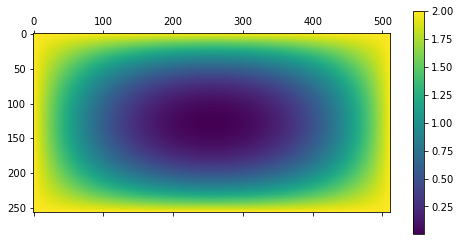

In [3]:
plt.matshow(highpass((256, 512)))
plt.colorbar()

In [4]:
from skimage.transform import warp, AffineTransform

In [5]:
class AffineTransform2(AffineTransform):
    """Only adding matrix multiply to previous class"""
    def __matmul__(self, other):
        newmat = self.params @ other.params
        return AffineTransform2(matrix=newmat)
    
    def __eq__(self, other):
        return np.array_equal(self.params, other.params)
    
    def inverse(self):
        return AffineTransform2(matrix=np.linalg.inv(self.params))
    
AffineTransform2.__init__.__doc__ = AffineTransform.__init__.__doc__
AffineTransform2.__doc__ = AffineTransform.__doc__

In [6]:
# AffineTransform Tests
af1 = AffineTransform2(translation=(1, 2))
af2 = AffineTransform2(translation=(5, 3))
af3 = af1 @ af2
assert np.array_equal(af3.translation, (6, 5))
assert af3 == af2 @ af1

af1 = AffineTransform2(rotation=2)
af2 = AffineTransform2(rotation=1)
af3 = af1 @ af2
assert af3.rotation == 3
assert af3 == af2 @ af1

In [7]:
# testing
from skimage.data import astronaut
from skimage.color import rgb2gray

In [8]:
astro = rgb2gray(astronaut())[:,:]

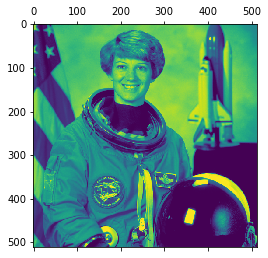

In [9]:
plt.matshow(astro)

In [10]:
logpolar(astro)[1]

1.0115737902145781

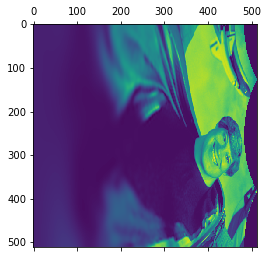

In [11]:
plt.matshow(logpolar(astro)[0])

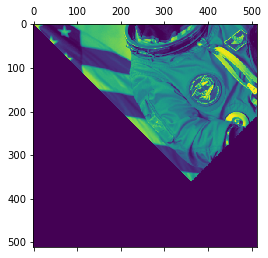

In [12]:
plt.matshow(warp(astro, AffineTransform2(rotation=np.pi/4)))

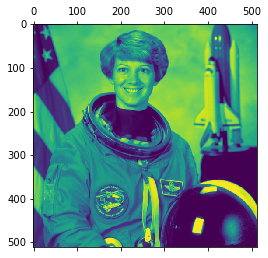

In [13]:
test_af = AffineTransform2(rotation=.02, translation=(9, -5), scale=(.95, .95))
astro2 = warp(astro, test_af)
plt.matshow(astro2)

In [28]:
from dphplotting import mip, slice_plot
from dphutils import slice_maker

In [30]:
def localize_peak(data):
    """
    Small utility function to localize a peak center. Assumes passed data has
    peak at center and that data.shape is odd and symmetric. Then fits a
    parabola through each line passing through the center. This is optimized
    for FFT data which has a non-circularly symmetric shaped peaks.
    """
    # make sure passed data is symmetric along all dimensions
    if not len(set(data.shape)) == 1:
        print("data.shape = {}".format(data.shape))
        return 0, 0
    # pull center location
    center = data.shape[0] // 2
    # generate the fitting lines
    my_pat_fft_suby = data[:, center]
    my_pat_fft_subx = data[center, :]
    # fit along lines, consider the center to be 0
    x = np.arange(data.shape[0]) - center
    xfit = np.polyfit(x, my_pat_fft_subx, 2)
    yfit = np.polyfit(x, my_pat_fft_suby, 2)
    # calculate center of each parabola
    x0 = -xfit[1] / (2 * xfit[0])
    y0 = -yfit[1] / (2 * yfit[0])
    # NOTE: comments below may be useful later.
    # save fits as poly functions
    # ypoly = np.poly1d(yfit)
    # xpoly = np.poly1d(xfit)
    # peak_value = ypoly(y0) / ypoly(0) * xpoly(x0)
    # #
    # assert np.isclose(peak_value,
    #                   xpoly(x0) / xpoly(0) * ypoly(y0))
    # return center
    return y0, x0

def find_max(data):
    coords = np.unravel_index(data.argmax(), data.shape)
    d_coords = localize_peak(data[slice_maker(*coords, 3)])
    return np.array(coords) + np.array(d_coords)

In [70]:
def logpolar(image, angles=None, radii=None):
    """Return log-polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = np.empty((angles, radii), dtype=np.float64)
    theta.T[:] = -np.linspace(0, np.pi, angles, endpoint=False)
    #d = radii
    d = np.hypot(shape[0]-center[0], shape[1]-center[1])
    log_base = 10.0 ** (np.log10(d) / (radii))
    radius = np.empty_like(theta)
    radius[:] = np.power(log_base, np.arange(radii, dtype=np.float64)) - 1.0
    x = (radius / shape[1] * shape[0]) * np.sin(theta) + center[0]
    y = radius * np.cos(theta) + center[1]
    output = np.empty_like(x)
    ndii.map_coordinates(image, [x, y], output=output)
    return output, log_base


def translation(im0, im1):
    """Return translation vector to register images."""
    shape = im0.shape
    f0 = fft2(im0)
    f1 = fft2(im1)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = np.unravel_index(np.argmax(ir), shape)
    dt0, dt1 = localize_peak(ir[slice_maker(t0, t1, 3)])
    t0, t1 = t0 + dt0, t1 + dt1,
    if t0 > shape[0] // 2:
        t0 -= shape[0]
    if t1 > shape[1] // 2:
        t1 -= shape[1]
    return AffineTransform2(translation=(-t1, -t0))


def similarity(im0, im1):
    """Return similarity transformed image im1 and transformation parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector.

    A similarity transformation is an affine transformation with isotropic
    scale and without shear.

    Limitations:
    Image shapes must be equal and square.
    - can fix with padding, non-square images can be handled either with padding or
        better yet compensating for uneven image size
    All image areas must have same scale, rotation, and shift.
    - tiling if necessary...
    Scale change must be less than 1.8.
    - why?
    No subpixel precision.
    - fit peak position or upsample as in (https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/register_translation.py)

    """
    if im0.shape != im1.shape:
        raise ValueError("Images must have same shapes.")
    elif len(im0.shape) != 2:
        raise ValueError("Images must be 2 dimensional.")
    shape_ratio = im0.shape[0] / im0.shape[1]
    # calculate fourier images of inputs
    f0 = fftshift(abs(fft2(im0)))
    f1 = fftshift(abs(fft2(im1)))
    # high pass filter fourier images
    h = highpass(f0.shape)
    f0 *= h
    f1 *= h
#     del h
    # convert images to logpolar coordinates.
    f0, log_base = logpolar(f0)
    f1, log_base = logpolar(f1)
    # fourier transform again ?
    f0 = fft2(f0)
    f1 = fft2(f1)
    # calculate impulse response
    r0 = abs(f0) * abs(f1)
    ir_cmplx = ifft2((f0 * f1.conjugate()) / r0)
    ir = abs(ir_cmplx)
    # find max
    i0, i1 = np.array(np.unravel_index(np.argmax(ir), ir.shape))
    di0, di1 = localize_peak(ir[slice_maker(i0, i1, 5)])
    i0, i1 = i0 + di0, i1 + di1
    # calculate the angle
    angle = i0 / ir.shape[0]
    # and scale
    scale = log_base ** i1
    # if scale is too big, try complex conjugate of ir
    if scale > 1.8:
        ir = abs(ir_cmplx.conjugate())
        i0, i1 = np.array(np.unravel_index(np.argmax(ir), ir.shape))
        di0, di1 = localize_peak(ir[slice_maker(i0, i1, 5)])
        i0, i1 = i0 + di0, i1 + di1
        angle = -i0 / ir.shape[0]
        scale = 1.0 / (log_base ** i1)
        if scale > 1.8:
            raise ValueError("Images are not compatible. Scale change > 1.8")
    # center the angle
    angle *= np.pi
    if angle < -np.pi / 2:
        angle += np.pi
    elif angle > np.pi / 2:
        angle -= np.pi
    # apply scale and rotation
    # first move center to 0, 0
    # center shift is reversed because of definition of AffineTransform2
    center_shift = np.array(im1.shape)[::-1] // 2
    af = AffineTransform2(translation = center_shift)
    # then apply scale and rotation
    af @= AffineTransform2(scale=(scale, scale), rotation=angle)
    # move back to center of image
    af @= AffineTransform2(translation=-center_shift)
    # apply transformation
    im2 = warp(im1, af)
    # now calculate translation
    af @= translation(im0, im2)
    im2 = warp(im1, af)

    return im2, af

In [71]:
im2, af = similarity(astro, astro2)

NameError: name 'AffineTransform2' is not defined

In [17]:
resid = (af @ test_af)
print(resid.rotation)
print(resid.scale)
print(resid.shear)
print(resid.translation)

0.0007456269549796895
(0.9967395227647309, 0.9967395227647309)
0.0
[ 1.1321331   0.84033334]


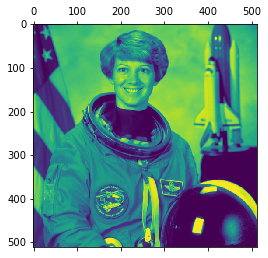

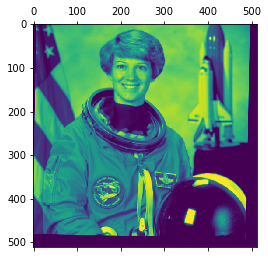

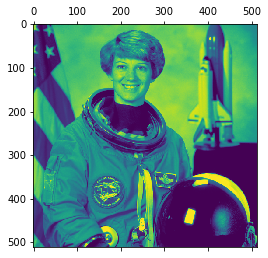

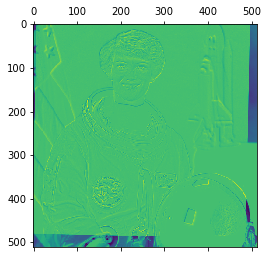

In [18]:
plt.matshow(astro2)
# test_af3 = AffineTransform2(matrix=np.linalg.inv(test_af.params))
# plt.matshow(warp(astro2, test_af3))
plt.matshow(im2)
plt.matshow(astro)
plt.matshow(im2 - astro)

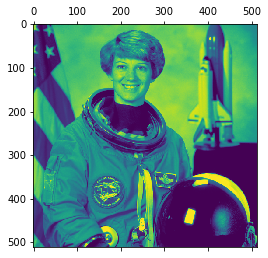

In [19]:
plt.matshow(astro)

# OpenCV

In [20]:
import cv2

In [21]:
def register_ECC(im0, im1, warp_mode = cv2.MOTION_AFFINE, number_of_iterations = 50, termination_eps = 1e-3):
    """
    # Specify the number of iterations.

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations;
    """
    # Find size of image1
    sz = im0.shape

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    cc, warp_matrix = cv2.findTransformECC (im0, im1, warp_matrix, warp_mode, criteria)
    
    return AffineTransform2(matrix=np.vstack((warp_matrix, (0,0,1))))

In [22]:
# Find size of image1
sz = astro.shape
 
# Define the motion model
warp_mode = cv2.MOTION_AFFINE
 
# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    
# Specify the number of iterations.
number_of_iterations = 500;
 
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-8;
 
# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
# Run the ECC algorithm. The results are stored in warp_matrix.
%time (cc, warp_matrix) = cv2.findTransformECC (astro.astype(np.float32), astro2.astype(np.float32),warp_matrix, warp_mode, criteria)
print(warp_matrix)
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography 
    astro2_aligned = cv2.warpPerspective(astro2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    # Use warpAffine for Translation, Euclidean and Affine
    astro2_aligned = cv2.warpAffine(astro2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

Wall time: 45.3 s
[[ 1.05234015  0.02101009 -9.32685947]
 [-0.02131254  1.05180502  5.72970867]]


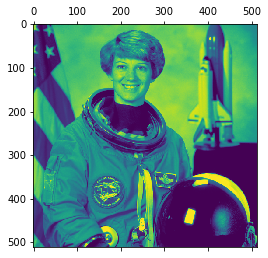

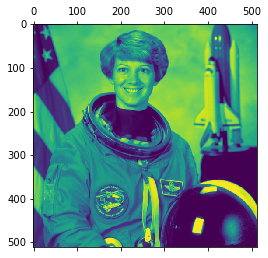

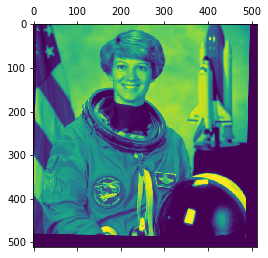

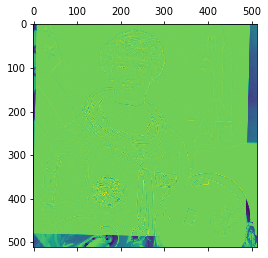

In [27]:
af2 = register_ECC(astro.astype(np.float32), astro2.astype(np.float32))
astro2_aligned = warp(astro2, af2)
# Show final results
plt.matshow(astro)
plt.matshow(astro2)
plt.matshow(astro2_aligned)
plt.matshow(astro2_aligned - astro)

In [28]:
%timeit astro2_aligned = warp(astro2, af2)
%timeit astro2_aligned = cv2.warpAffine(astro2, af2.params[:2], (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

100 loops, best of 3: 11.3 ms per loop
1000 loops, best of 3: 1.01 ms per loop


In [29]:
resid = (af2 @ test_af)
print(resid.rotation)
print(resid.scale)
print(resid.shear)
print(resid.translation)

-0.0002580685546785208
(0.9999228541225064, 0.9994190141449747)
0.00029571561033573
[ 0.03901022  0.27847726]


# Actual stuff

In [2]:
import imreg_dft
# from imreg_dft import translation as trans_imreg_dft
%load_ext autoreload
%autoreload 2
from imreg_dph import register_ECC, similarity, translation

In [3]:
import glob
from skimage.external import tifffile as tif

In [32]:
paths = sorted(glob.iglob("../17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/*.tif"))

In [33]:
pairs = [(paths[i], paths[i + 1]) for i in range(len(paths) - 1)]

In [34]:
pairs[:4]

[('../17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens\\NVision40-3802_17-03-31_000030_0-0-0_InLens.tif',
  '../17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens\\NVision40-3802_17-03-31_000133_0-0-0_InLens.tif'),
 ('../17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens\\NVision40-3802_17-03-31_000133_0-0-0_InLens.tif',
  '../17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens\\NVision40-3802_17-03-31_000237_0-0-0_InLens.tif'),
 ('../17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens\\NVision40-3802_17-03-31_000237_0-0-0_InLens.tif',
  '../17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens\\NVision40-3802_17-03-31_000340_0-0-0_InLens.tif'),
 ('../17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens\\NVision40-3802_17-03-31_000340_0-0-0_InLens.tif',
  '../17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens\\NVision40-3802_17-03-31_000444_0-0-0_InLens.tif')]

In [22]:
def load_and_register(path0, path1, meth=translation, *args, **kwargs):
    data0 = tif.imread(path0)
    data1 = tif.imread(path1)
    
    return meth(data0, data1, *args, **kwargs)

In [9]:
import pyfftw
pyfftw.interfaces.cache.enable()

In [41]:
%time af = load_and_register(*pairs[1], imreg_dft.imreg._translation)
af

Wall time: 6.5 s


(array([ 0.86643268,  0.01526693]), 0.14009271138651566)

In [40]:
%time af = load_and_register(*pairs[1], translation)
af.translation

Wall time: 5.72 s


array([-0.05163278, -0.57147932])

In [42]:
a = np.arange(10)

In [44]:
a.__repr__()

'array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])'

In [20]:
af

{'angle': 0,
 'success': 0.14009271138651566,
 'tvec': array([ 0.86643268,  0.01526693])}

In [14]:
to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1) for path0, path1 in pairs])

In [17]:
with ProgressBar():
    results = to_compute.compute(get=dask.multiprocessing.get)

[########################################] | 100% Completed |  1hr 13min 56.3s


In [8]:
results_trans = np.load("results_trans.npy")

In [9]:
results_trans[:10]

array([[-3.63993847, -1.93194327],
       [-1.        ,  0.        ],
       [-0.5       , -0.5       ],
       [ 3.        ,  1.        ],
       [-3.51210019, -1.46033229],
       [ 3.        ,  1.        ],
       [-0.5       ,  0.5       ],
       [-0.5       , -0.5       ],
       [-0.5       , -0.5       ],
       [-0.5       , -0.5       ]])

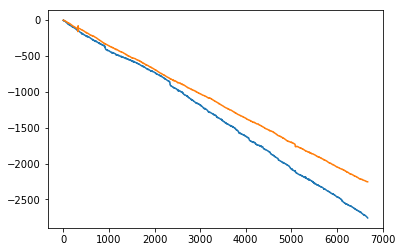

In [10]:
plt.plot(results_trans.cumsum(0))

In [ ]:
to_compute2 = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, trans_imreg_dft) for path0, path1 in pairs])
with ProgressBar():
    results_trans_dft = to_compute2.compute(get=dask.multiprocessing.get)

[                                        ] | 0% Completed |  2min 11.6s

In [ ]:
to_compute3 = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_ECC,
                                    warp_mode=cv2.MOTION_EUCLIDEAN, num_iter=500, term_eps=1e-6)
                            for path0, path1 in pairs])
with ProgressBar():
    results_ecc = to_compute3.compute(get=dask.multiprocessing.get)

[                                        ] | 0% Completed | 48.0s

In [ ]:
to_compute4 = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_ECC,
                                    warp_mode=cv2.MOTION_AFFINE, num_iter=500, term_eps=1e-6)
                            for path0, path1 in pairs])
with ProgressBar():
    results_ecc_affine = to_compute4.compute(get=dask.multiprocessing.get)